### **Importing libs**

In [30]:
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Input, Concatenate, MaxPool2D, UpSampling2D, Add
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.image import resize, random_contrast
from keras import backend as K
from sklearn.model_selection import train_test_split
import os 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [31]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Visualization**

In [32]:
def visualize(img, label, alpha=0.4):
  fig, ax = plt.subplots(1, 3, figsize=(20, 20))
  ax[0].imshow(img)
  ax[0].set_title("Image")

  ax[1].imshow(label)
  ax[1].set_title("Mask")

  ax[2].imshow(img)
  ax[2].imshow(label, alpha=alpha)
  ax[2].set_title("Image with Mask")

In [33]:
img = img_to_array(load_img("/content/drive/MyDrive/Colab Notebooks/COVID_data/dataset/COVID(58)_json/img.png"))
label = img_to_array(load_img("/content/drive/MyDrive/Colab Notebooks/COVID_data/dataset/COVID(58)_json/label.png"))

label[label == 128.] = 1.

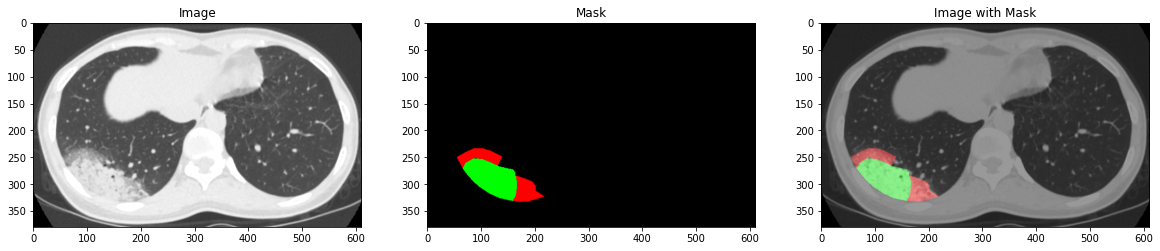

In [34]:
visualize(img.astype(np.uint8), label)

### **Data**

In [35]:
path = "/content/drive/MyDrive/Colab Notebooks/COVID_data/dataset"
names = os.listdir(path)

images = []
masks = []

In [36]:
for name in names:
  images.append(os.path.join(path, name, "img.png"))
  masks.append(os.path.join(path, name, "label.png"))

In [37]:
df = pd.DataFrame({"images": images,
                   "masks": masks})
df

images                                              masks
0    /content/drive/MyDrive/Colab Notebooks/COVID_d...  /content/drive/MyDrive/Colab Notebooks/COVID_d...
1    /content/drive/MyDrive/Colab Notebooks/COVID_d...  /content/drive/MyDrive/Colab Notebooks/COVID_d...
2    /content/drive/MyDrive/Colab Notebooks/COVID_d...  /content/drive/MyDrive/Colab Notebooks/COVID_d...
3    /content/drive/MyDrive/Colab Notebooks/COVID_d...  /content/drive/MyDrive/Colab Notebooks/COVID_d...
4    /content/drive/MyDrive/Colab Notebooks/COVID_d...  /content/drive/MyDrive/Colab Notebooks/COVID_d...
..                                                 ...                                                ...
218  /content/drive/MyDrive/Colab Notebooks/COVID_d...  /content/drive/MyDrive/Colab Notebooks/COVID_d...
219  /content/drive/MyDrive/Colab Notebooks/COVID_d...  /content/drive/MyDrive/Colab Notebooks/COVID_d...
220  /content/drive/MyDrive/Colab Notebooks/COVID_d...  /content/drive/MyDrive/Colab Notebooks/COVID_d...
221  /content/drive/MyDrive/Colab Notebooks/COVID_d...  /content/drive/MyDrive/Colab Notebooks/COVID_d...
222  /content/drive/MyDrive/Colab Notebooks/COVID_d...  /content/drive/MyDrive/Colab Notebooks/COVID_d...

[223 rows x 2 columns]

In [38]:
train_df, test_df = train_test_split(df, test_size=0.1)
train_df.shape, test_df.shape

((200, 2), (23, 2))

In [39]:
train_ids = list(train_df["images"])
train_mask = list(train_df["masks"])

test_ids = list(test_df["images"])
test_mask = list(test_df["masks"])

In [40]:
train_ids

['/content/drive/MyDrive/Colab Notebooks/COVID_data/dataset/COVID(79)_json/img.png',
 '/content/drive/MyDrive/Colab Notebooks/COVID_data/dataset/COVID(287)_json/img.png',
 '/content/drive/MyDrive/Colab Notebooks/COVID_data/dataset/COVID(276)_json/img.png',
 '/content/drive/MyDrive/Colab Notebooks/COVID_data/dataset/COVID(168)_json/img.png',
 '/content/drive/MyDrive/Colab Notebooks/COVID_data/dataset/COVID(201)_json/img.png',
 '/content/drive/MyDrive/Colab Notebooks/COVID_data/dataset/COVID(124)_json/img.png',
 '/content/drive/MyDrive/Colab Notebooks/COVID_data/dataset/COVID(826)_json/img.png',
 '/content/drive/MyDrive/Colab Notebooks/COVID_data/dataset/COVID(69)_json/img.png',
 '/content/drive/MyDrive/Colab Notebooks/COVID_data/dataset/COVID(150)_json/img.png',
 '/content/drive/MyDrive/Colab Notebooks/COVID_data/dataset/COVID(80)_json/img.png',
 '/content/drive/MyDrive/Colab Notebooks/COVID_data/dataset/COVID(65)_json/img.png',
 '/content/drive/MyDrive/Colab Notebooks/COVID_data/datase

In [43]:
class DataGenerator(Sequence):
  def __init__(self, ids, mask, batch_size=2, img_h=256, img_w=256, shuffle=True):
    self.ids = ids
    self.mask = mask
    self.batch_size = batch_size
    self.img_h = img_h
    self.img_w = img_w
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    return len(self.ids) // self.batch_size

  def __getitem__(self, index):
    indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]

    list_ids = [self.ids[i] for i in indexes]
    list_mask = [self.mask[i] for i in indexes]

    X, y = self.__data_generation(list_ids, list_mask)

    return tf.cast(X, dtype=tf.float32), tf.cast(y, dtype=tf.float32)

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.ids))

    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_ids, list_mask):
    X = []
    y = []

    for ids, mask in zip(list_ids, list_mask):
      img = img_to_array(load_img(ids))
      mask = img_to_array(load_img(mask))

      mask[mask == 128.] = 1.

      img = resize(img, (self.img_h, self.img_w))
      mask = resize(mask, (self.img_h, self.img_w))

      img = random_contrast(img, 0.2, 1)

      X.append(img)
      y.append(mask)

    return X, y

train_dataset = DataGenerator(train_ids, train_mask, batch_size=16)
test_dataset = DataGenerator(test_ids, test_mask, batch_size=4)

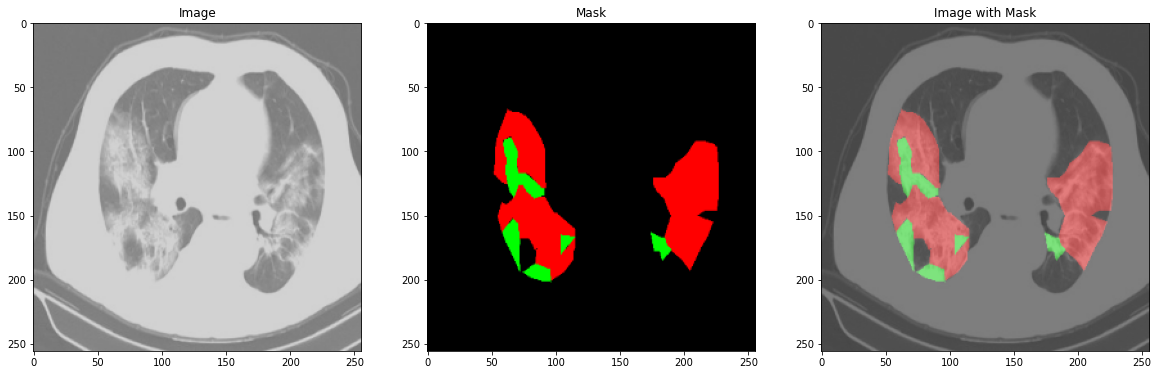

In [44]:
visualize(tf.cast(next(iter(train_dataset))[0][0], tf.uint8), next(iter(train_dataset))[1][0])

### **Creating and fitting model**

In [45]:
def resblock(X, f):
    X_copy = X
    
    X = Conv2D(f, kernel_size=(1, 1), kernel_initializer="he_normal")(X)
    X = BatchNormalization()(X)
    X = Activation("relu")(X)
    
    X = Conv2D(f, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(X)
    X = BatchNormalization()(X)
    
    X_copy = Conv2D(f, kernel_size=(1, 1), kernel_initializer="he_normal")(X_copy)
    X_copy = BatchNormalization()(X_copy)
    
    X = Add()([X, X_copy])
    X = Activation("relu")(X)
    
    return X

def upsample_concat(x, skip):
    X = UpSampling2D((2, 2))(x)
    merge = Concatenate()([X, skip])
    
    return merge

In [46]:
input_shape = (256, 256, 3)
X_input = Input(input_shape)

conv_1 = Conv2D(16, 3, activation="relu", padding="same", kernel_initializer="he_normal")(X_input)
conv_1 = BatchNormalization()(conv_1)
conv_1 = Conv2D(16, 3, activation="relu", padding="same", kernel_initializer="he_normal")(conv_1)
conv_1 = BatchNormalization()(conv_1)
pool_1 = MaxPool2D((2,2))(conv_1)

conv_2 = resblock(pool_1, 32)
pool_2 = MaxPool2D((2,2))(conv_2)

conv_3 = resblock(pool_2, 64)
pool_3 = MaxPool2D((2,2))(conv_3)

conv_4 = resblock(pool_3, 128)
pool_4 = MaxPool2D((2,2))(conv_4)

conv_5 = resblock(pool_4, 256)

up_1 = upsample_concat(conv_5, conv_4)
up_1 = resblock(up_1, 128)

up_2 = upsample_concat(up_1, conv_3)
up_2 = resblock(up_2, 64)

up_3 = upsample_concat(up_2, conv_2)
up_3 = resblock(up_3, 32)

up_4 = upsample_concat(up_3, conv_1)
up_4 = resblock(up_4, 16)

output = Conv2D(3, (1,1), kernel_initializer="he_normal", padding="same", activation="sigmoid")(up_4)

model = Model(X_input, output)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 256, 256, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_26 (BatchNo (None, 256, 256, 16) 64          conv2d_27[0][0]                  
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 256, 256, 16) 2320        batch_normalization_26[0][0]     
____________________________________________________________________________________________

In [47]:
def iou(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2])
  union = K.sum(y_true, [1, 2]) + K.sum(y_pred, [1, 2]) - intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

In [48]:
loss = "binary_crossentropy"
optimizer = "adam"
metrics = [iou, Precision(), Recall()]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [49]:
model.load_weights("/content/drive/MyDrive/Colab Notebooks/COVID_data/models/saved model/seg_model_w/weights")

In [50]:
history = model.fit(train_dataset, epochs=50, validation_data=test_dataset)

Epoch 1/50
12/12 [==============================] - 8s 400ms/step - loss: 0.0027 - iou: 0.7410 - precision_1: 0.9770 - recall_1: 0.9068 - val_loss: 0.0034 - val_iou: 0.7732 - val_precision_1: 0.9796 - val_recall_1: 0.9020
Epoch 2/50
12/12 [==============================] - 4s 330ms/step - loss: 0.0018 - iou: 0.7403 - precision_1: 0.9853 - recall_1: 0.9248 - val_loss: 0.0028 - val_iou: 0.7899 - val_precision_1: 0.9856 - val_recall_1: 0.9018
Epoch 3/50
12/12 [==============================] - 4s 339ms/step - loss: 0.0017 - iou: 0.7302 - precision_1: 0.9867 - recall_1: 0.9234 - val_loss: 0.0033 - val_iou: 0.8048 - val_precision_1: 0.9800 - val_recall_1: 0.8874
Epoch 4/50
12/12 [==============================] - 4s 340ms/step - loss: 0.0016 - iou: 0.7312 - precision_1: 0.9907 - recall_1: 0.9174 - val_loss: 0.0031 - val_iou: 0.8188 - val_precision_1: 0.9779 - val_recall_1: 0.9173
Epoch 5/50
12/12 [==============================] - 4s 331ms/step - loss: 0.0016 - iou: 0.7514 - precision_1: 0.

In [51]:
model.save("/content/drive/MyDrive/Colab Notebooks/COVID_data/models/saved model/seg_model")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/COVID_data/models/saved model/seg_model/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [52]:
model.save_weights("/content/drive/MyDrive/Colab Notebooks/COVID_data/models/saved model/seg_model_w/weights")

# **Evaluating**

In [53]:
model.evaluate(test_dataset)

5/5 [==============================] - 0s 60ms/step - loss: 0.0029 - iou: 0.8404 - precision_1: 0.9864 - recall_1: 0.9043


[0.0029224883764982224,
 0.840435802936554,
 0.9864449501037598,
 0.904295802116394]

In [54]:
def predict(img):
  img = resize(img, (256, 256))
  mask = model.predict(img[None, ...])
  return img, mask[0, ...]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


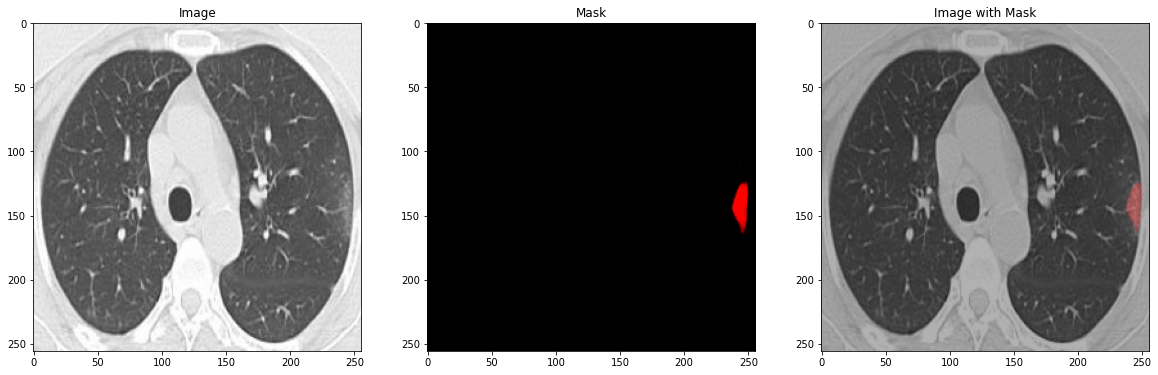

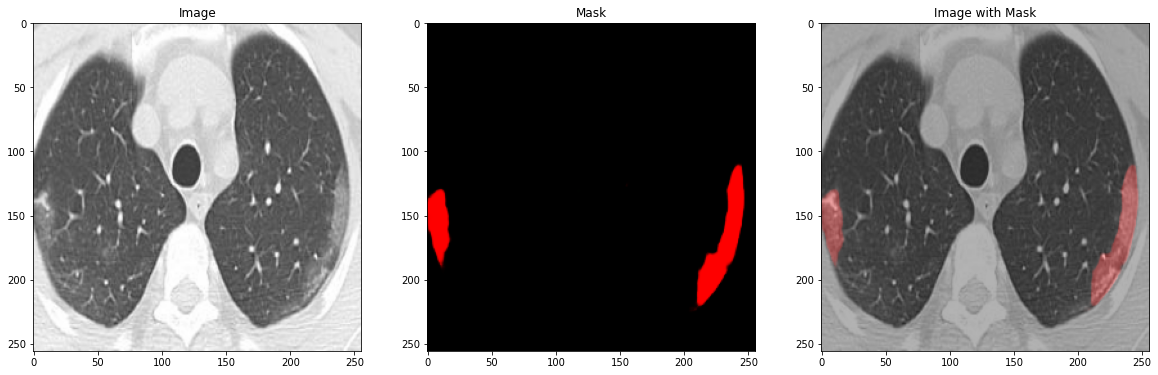

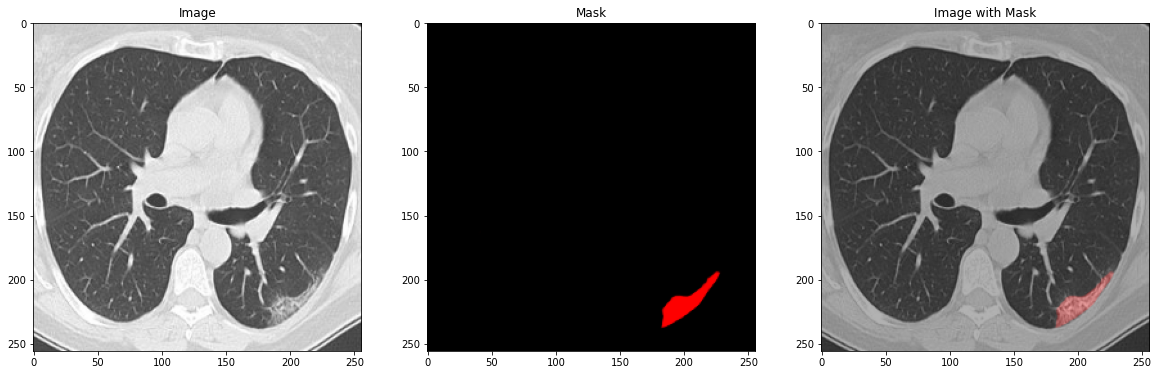

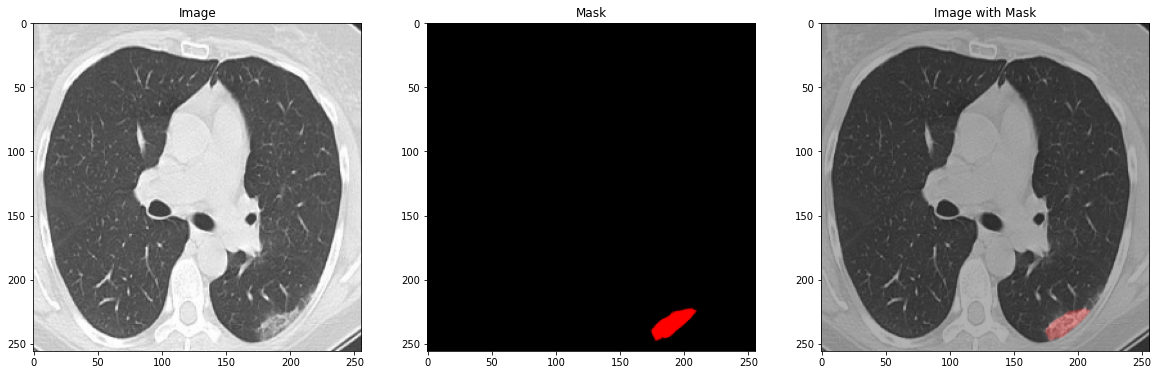

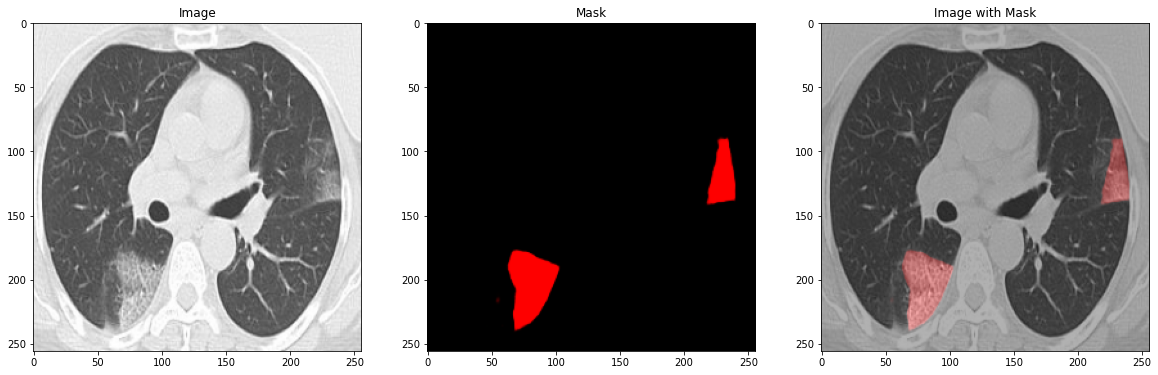

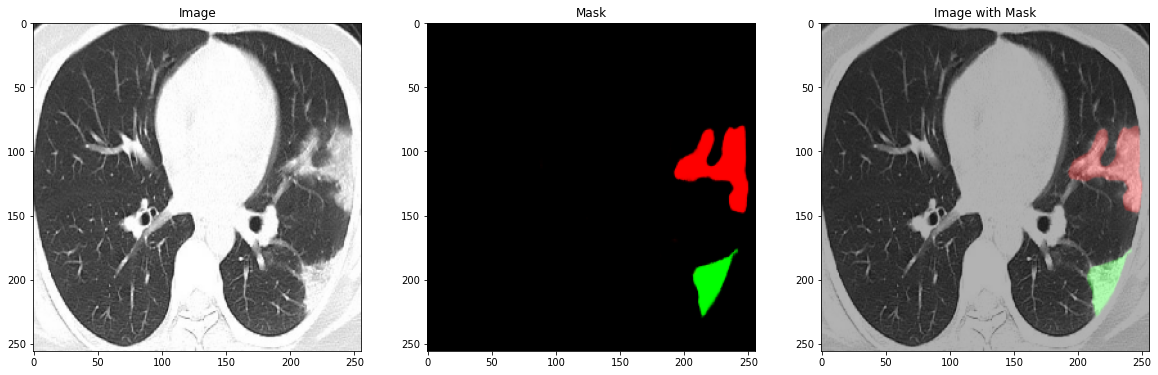

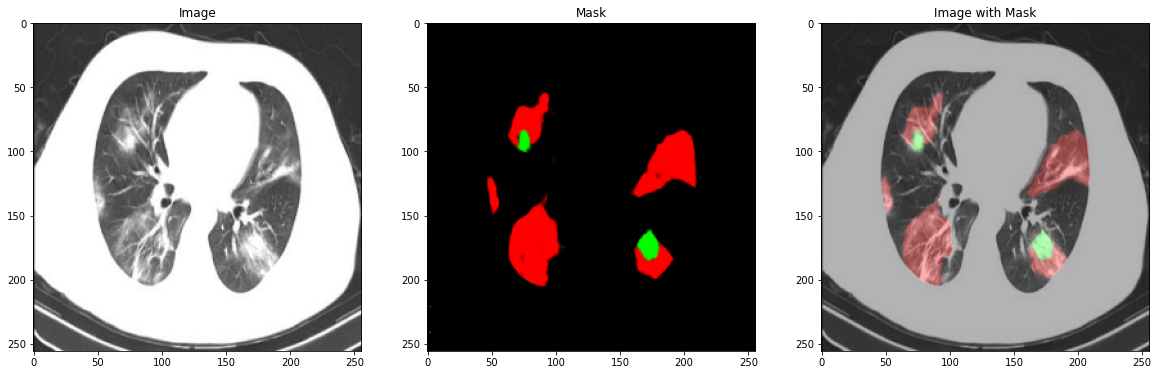

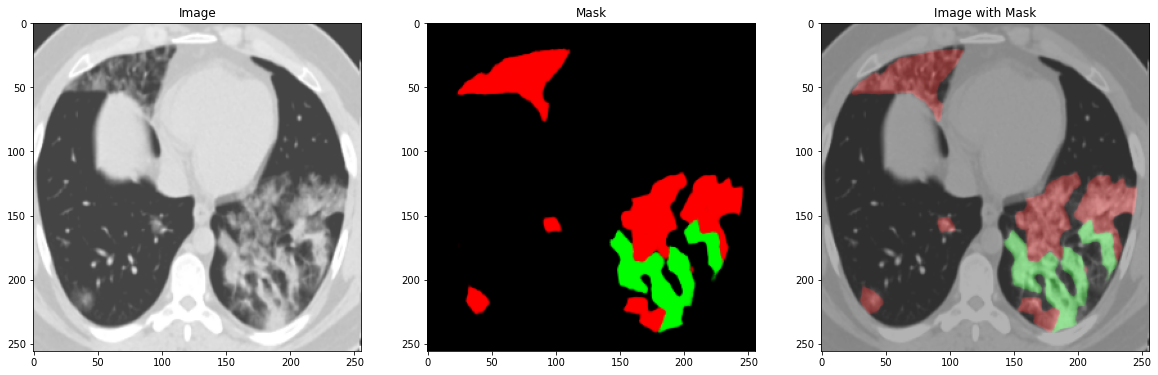

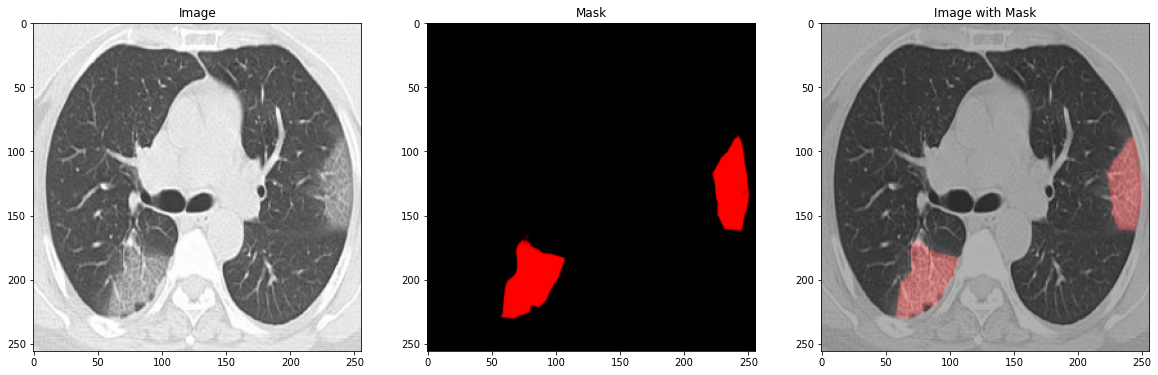

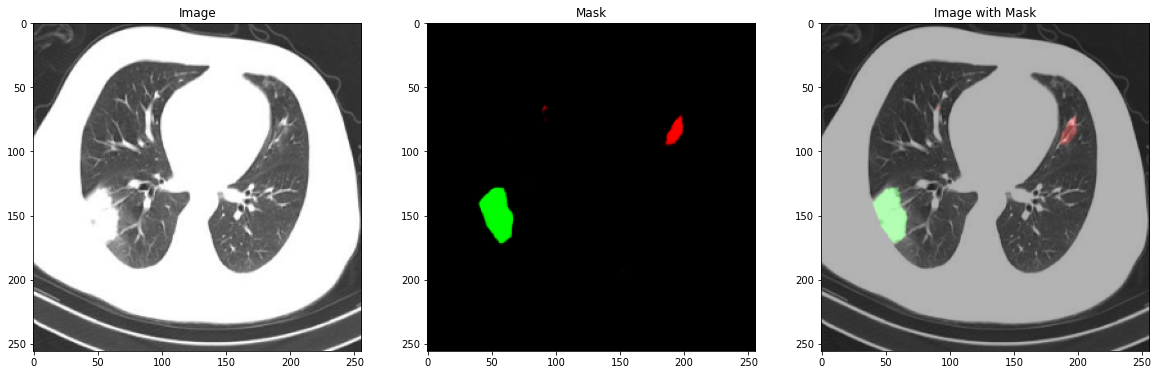

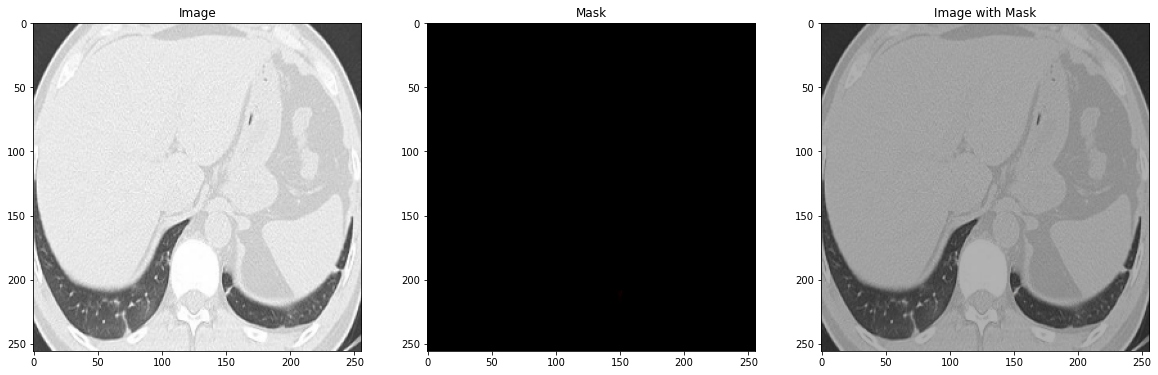

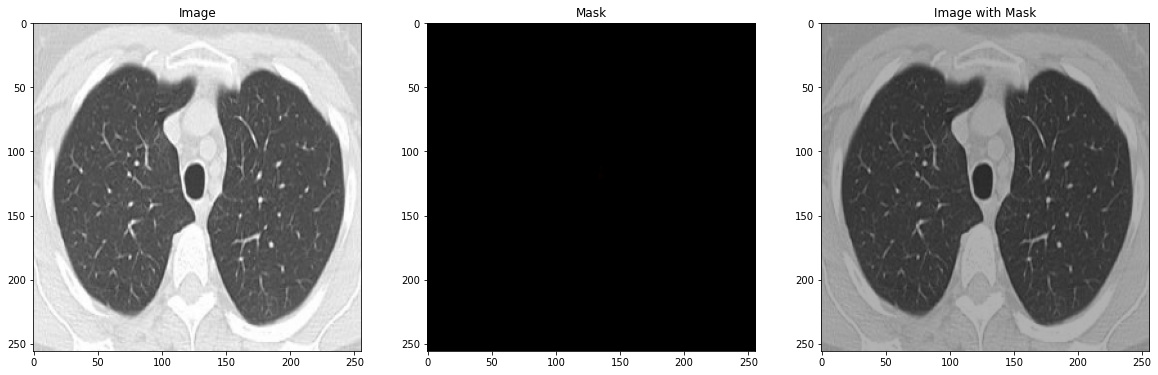

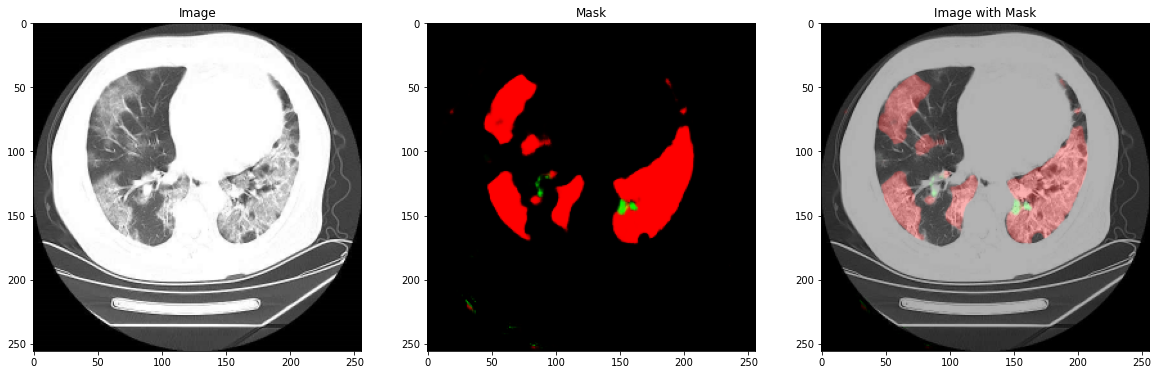

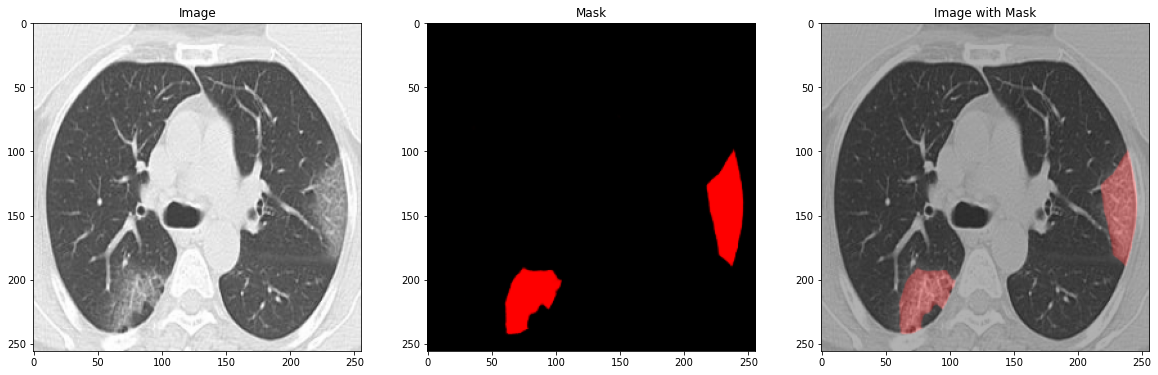

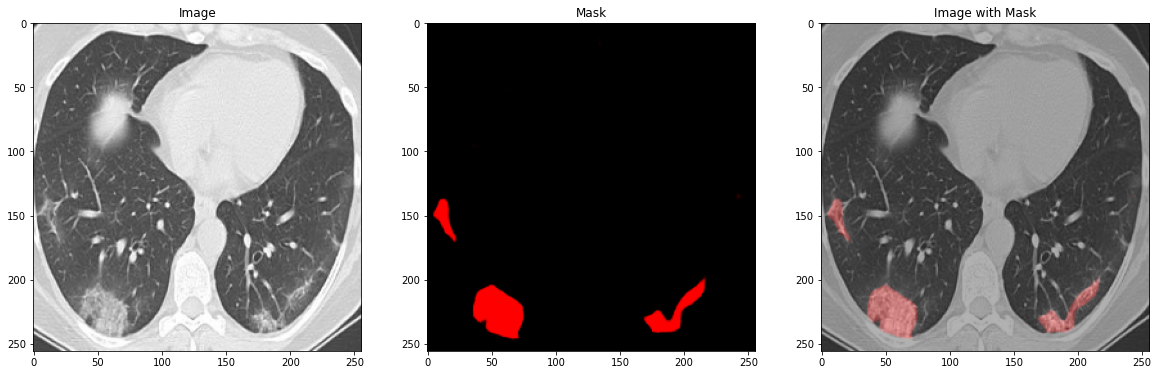

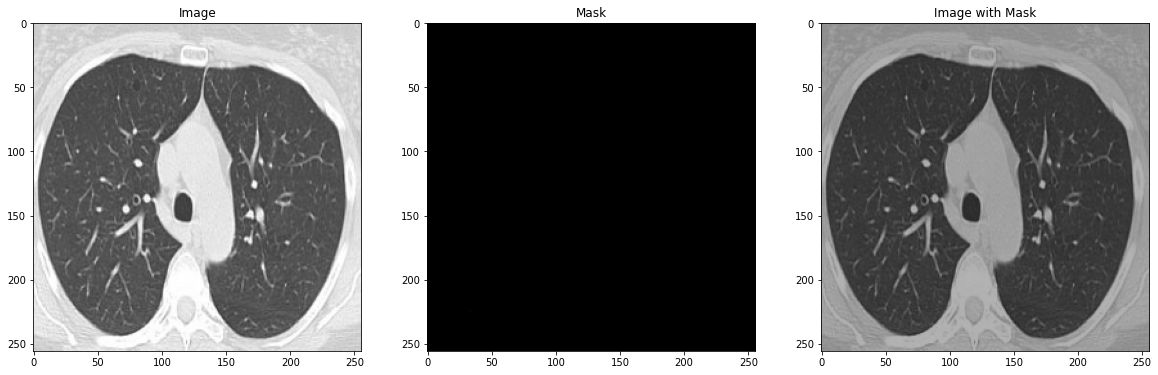

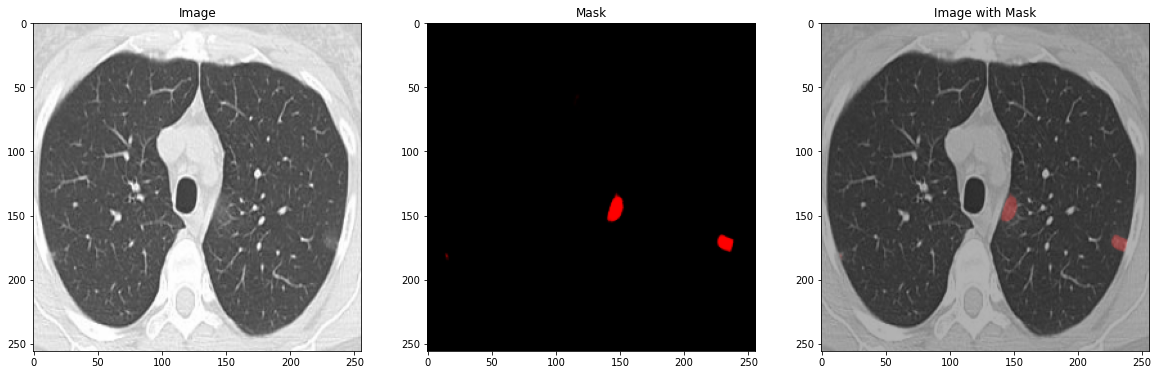

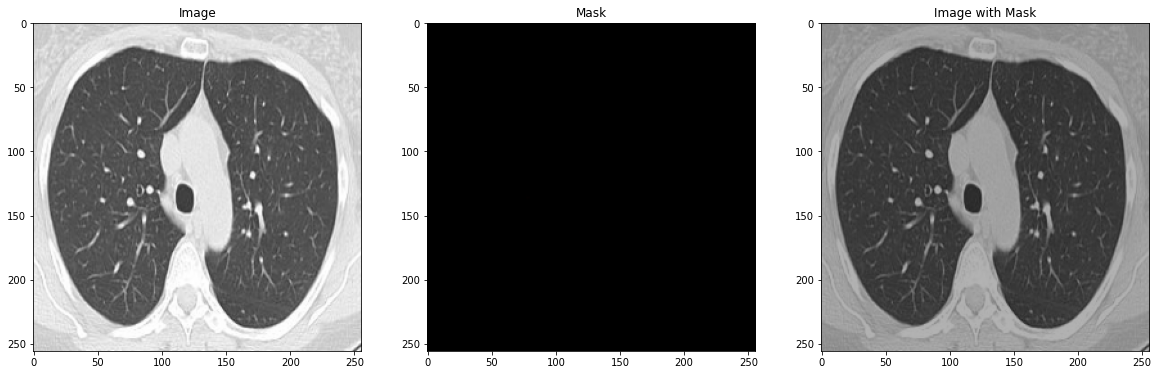

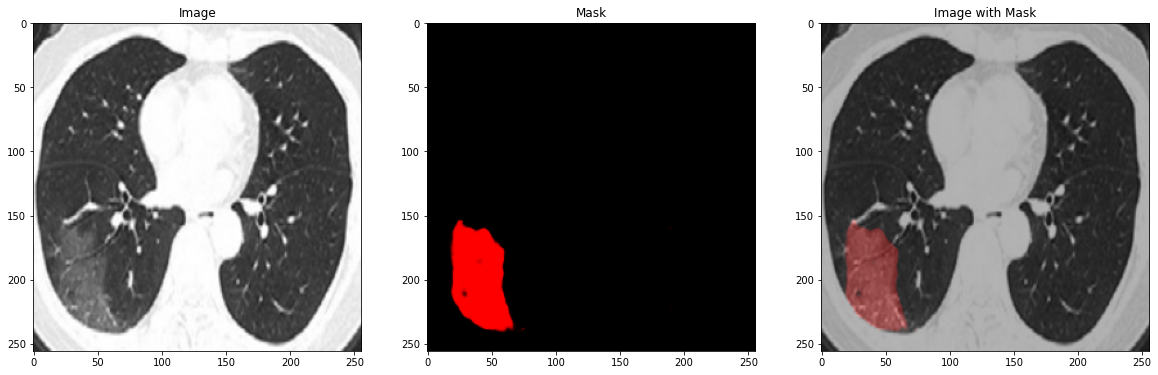

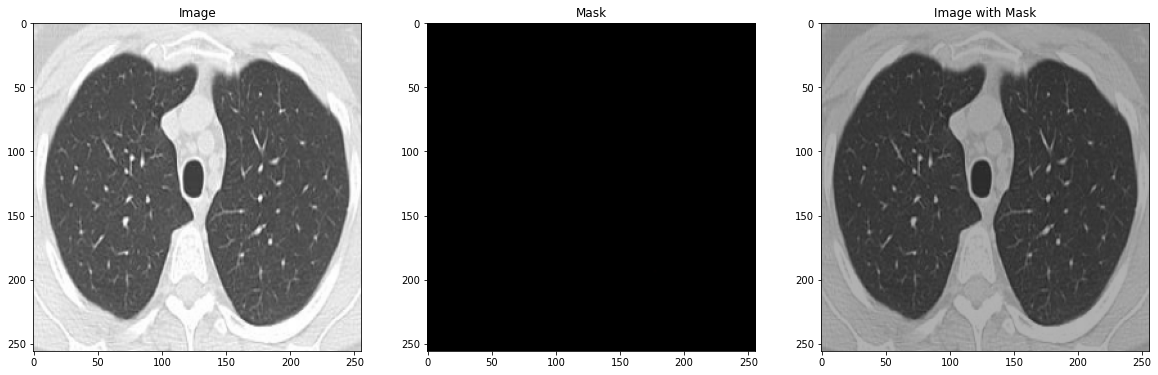

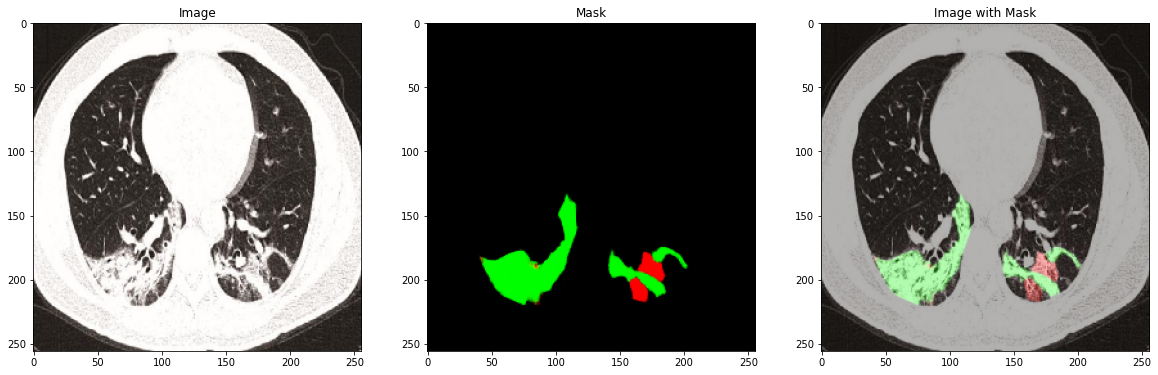

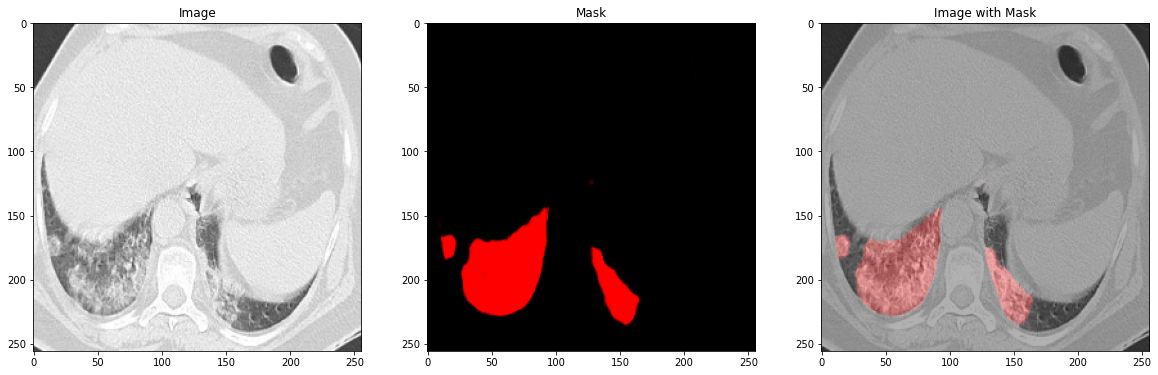

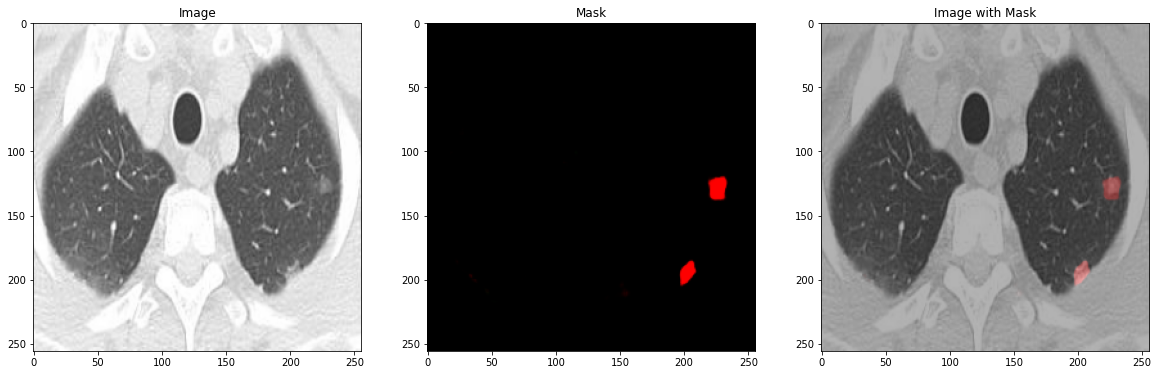

In [55]:
for img in test_ids:
  img = img_to_array(load_img(img))
  img, mask = predict(img)
  visualize(tf.cast(img, dtype=tf.uint8), mask, alpha=0.3)

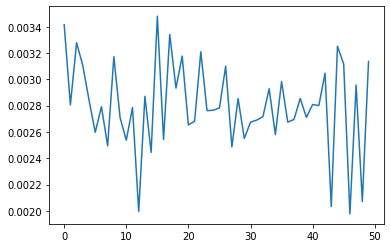

In [56]:
plt.plot(history.history["val_loss"])